In order to estimate the frequency of >140m impactors, we narrowed down our crater data to only include craters within the lunar mare Oceanus Procellarum . Because we know the approximate age at which this lunar feature was formed, 1963 ± 57 million years ago (Che et al., 2021) , we can use the formation of this mare as an interval marker for the timeline of impacts to calculate an annual impact rate. 

In [174]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import Eq, Symbol, solve

craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

#indexing from a certain row
print (craters[60:])

       Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
60             60  01-1-000026       61.6941      172.3650       61.6953   
61             61  01-1-000027       62.8265      177.1930       62.8215   
62             62  01-1-000028       62.5616      175.1740       62.5700   
63             63  01-1-000029       62.4650      177.6320       62.4484   
64             64  01-1-000030       63.3087      179.7250       63.3068   
...           ...          ...           ...           ...           ...   
83056     1296791  10-2-014997      -65.6258      203.5000      -65.6216   
83057     1296792  10-3-000000      -60.0296      178.7090      -60.0301   
83058     1296793  10-3-000003      -66.7921      219.3790      -66.7951   
83059     1296794  10-3-000004      -79.8374       62.1794      -79.8408   
83060     1296795  10-3-000005      -79.6855       61.9220      -79.7055   

       LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
60        

A Monte Carlo simulation was applied to generate possible impactors of various diameters, velocities, densities, and impact angles. These randomly generated asteroids were used to create a distribution of resultant crater sizes. Craters whose sizes fell within the range of crater sizes for asteroids larger than 140m can then be ascertained. 

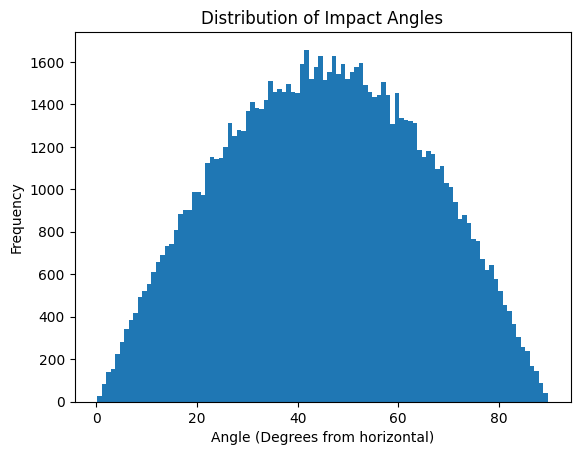

In [175]:
# generate random impact scenarios for Monte Carlo modeling
import random # importing the Python random library

angles=[] #declare list
for _ in range(100000): # asking this to do stuff 10000 times
    u=random.uniform(0,1) # random number between 0 and 1
    angle=(90/np.pi)*np.arccos(2*u-1) # Distribution of angles according to Mathias et al.
    angles.append(angle)

plt.hist(angles, bins=100)
plt.xlabel('Angle (Degrees from horizontal)')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Angles')
plt.show()

In [177]:
# generate the ditribution of densities according to Mathias et al.
asteroid_densities=[3.38,3.3,3.19,2.27,6.75,7.15,2.84,3.12,2.86] # densities of different asteroid types
densities=[]

for _ in range(10000):
       # density=np.random.normal(np.mean(asteroid_densities[i]), np.std(std_densities[i]), size=None)
       # densities.append(density)
    density=min(asteroid_densities)*random.weibullvariate(1, 1.7)+1
    densities.append(density)


Text(0.5, 1.0, 'Density Distribution')

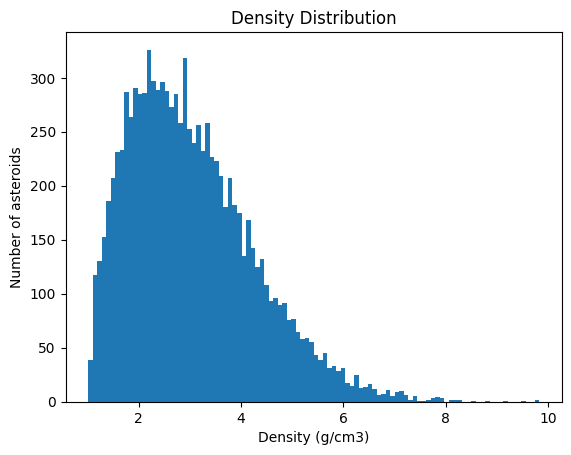

In [178]:
plt.hist(densities, bins=100)
plt.xlabel('Density (g/cm3)')
plt.ylabel('Number of asteroids')
plt.title('Density Distribution')

Maximum velocity: 42.92 km/s


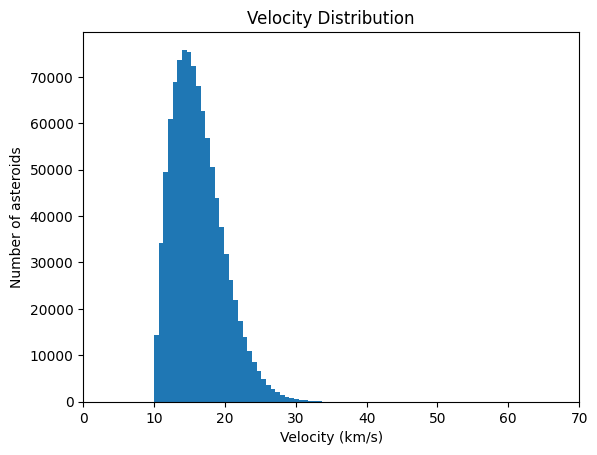

In [179]:
#generate distribution of velocities

velocities=[]
for _ in range(1000000):
	velocity=10*random.weibullvariate(.7, 1.8)+10
	velocities.append(velocity)
# Let's check that this looks correct.
plt.hist(velocities,bins=50) #again we'll check the results to make sure they make sense
plt.xlabel("Velocity (km/s)") 
plt.ylabel("Number of asteroids")
plt.title('Velocity Distribution')
plt.xlim(0,70)
#Is the maximum value what we want it to be?
print("Maximum velocity:",'%.2f' %max(velocities),"km/s")


In order to relate the craters in the database to the sizes of the asteroids that made them, a formula (Melosh, 1989) was used that relates the crater size, asteroid density, moon density, asteroid velocity, acceleration of gravity at the moon’s surface, and the angle of impact. The original equation solves for crater size, so a “solve” function was employed to find our single unknown using placeholder values. The distributions found earlier were then input into the equation to find all of the craters made by asteroids larger than 140 meters in the dataset.

In [184]:
D_tc = 234 #PLACEHOLDER Crater diameter at level of ground surface (m)
rho_p = 6000  # PLACEHOLDER Density of asteroid (projectile)(kg/m^3)
rho_t = 2550 #Density of (moon) target (kg/m^3)
#L = 140 #SOLVING FOR -- Diameter of projectile (asteroid) (m)
v_i = 18 #PLACEHOLDER impact velocity (km/s)
g = 1.625 #surface gravity (m/s^2)
theta = 3.14159/2 #PLACEHOLDER impact angle, referencing from horizontal (rad)


L = Symbol('L')


a = Symbol('a')
b = Symbol('b')
c = Symbol('c')
d = Symbol('d')
e = Symbol('e')


a = (1.161*(rho_p/rho_t)**(1/3))
b = (L**.78)
c = (v_i**(0.44))
d = (g**(-0.22))
e = (math.sin(theta)**(1/3))

L = Symbol('L')
eqn = Eq(D_tc, a*b*c*d*e)

h = solve(eqn,L)
print ("asteroid diameter (m)", h)


asteroid diameter (m) [140.248708504796]


The last thing to do was filter the dataset into the craters inside the largest maria, Oceanus Procellarum, whose location and boundary region was approximated using the coordinates of the center of the mare. The mare’s outline was approximated as a circle for the sake of simplicity. An inscribed square was then created within that circle, providing minimum and maximum latitudes and longitudes. This area served as our observation area for simplicity of code and better ensure that we did not include any craters that are outside of the non-abstracted area of the mare. All asteroids with center coordinates within this square were filtered out as part of our dataset. This filtered dataset was then filtered to extract craters that were created by asteroids greater than 140m. 

In [185]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

# Find all craters likely caused by asteroids >140m
min_crater_size=100 #Currently an arbitrary value

half_distance=30.221 #This distance is the number of degrees you would need to travel from the center of the mare to the side of an inscribed rectangle within it
center_long=302.6   #This is the longitude coordinate of the center of the mare
center_lat=18.4 #This is the latitude coordinate of the center of the mare

#The following lines calculate the bounds of the box we are observing
max_long=center_long+half_distance
min_long=center_long-half_distance
max_lat=center_lat+half_distance
min_lat=center_lat-half_distance

big_craters=craters[(craters["DIAM_CIRC_IMG"] >= min_crater_size)] #Filters out any craters smaller than the minimum size

#Filter out Longitudes out of our observation area
filtered_craters=big_craters[(big_craters["LON_CIRC_IMG"] >= min_long) & (big_craters["LON_CIRC_IMG"] <= max_long)]

#Filter out Latitudes out of our observation area
filtered_craters=filtered_craters[(filtered_craters["LAT_CIRC_IMG"] >= min_lat) & (filtered_craters["LAT_CIRC_IMG"] <= max_lat)]
print(filtered_craters)

       Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
1               1  00-1-000001      44.77630       328.602      44.40830   
19             19  00-1-000019      -4.78646       291.203      -6.09377   
30943      396756  04-1-000704       2.22827       292.620       2.23209   
30965      396778  04-1-000726      21.55850       287.930      21.55380   
30966      396779  04-1-000727      23.03760       283.275      23.03580   
32370      450260  04-2-000002      46.55980       275.798      46.52480   
32952      461990  04-2-019014       2.77389       283.513       2.76495   
32971      462009  04-2-019033      12.14690       279.797      11.84030   
33040      462376  05-1-000014      -3.25265       315.839      -3.23267   
33046      462382  05-1-000020      -2.79050       285.577      -2.78749   
33165      462501  05-1-000139     -10.71070       317.521     -10.74930   

       LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
1         

#### Works cited

approximate ratios between the diameters of terrestrial impact craters and the causative incident asteroids | Monthly Notices of the Royal
Astronomical Society | Oxford Academic.

Carry, B. 2012, Planetary and Space Science, 73, 98

Che, X., Nemchin, A., Liu, D., et al. 2021, Science, 374 (American Association for the Advancement of Science), 887

Hirt, C., & Featherstone, W. E. 2012, Earth and Planetary Science Letters, 329–330, 22
Hughes, D. W. 2003, Monthly Notices of the Royal Astronomical Society, 338, 999
Ivanov, B. A., & Artemieva, N. A. 2002, in Catastrophic events and mass extinctions: impacts and beyond (Geological Society of America)

Jansen, J. C., Andrews-Hanna, J. C., Li, Y., et al. 2017, Icarus, 291, 107

Mathias, D. L., Wheeler, L. F., & Dotson, J. L. 2017, Icarus, 289, 106

Mazrouei, S., Ghent, R. R., Bottke, W. F., Parker, A. H., & Gernon, T. M. 2019, Science, 363 (American Association for the Advancement of Science), 253

Melosh, H. J. 2011, Planetary Surface Processes (1st ed.; Cambridge University Press)

NASA’s Moon Data Sheds Light on Earth’s Asteroid Impact History - NASA Science.

Nelson, D. M., Koeber, S. D., Daud, K., Robinson, M. S., Watters, T. R., Banks, M. E., & Williams, N. R. (2014, March). Mapping lunar maria extents and lobate scarps using LROC image products. In Lunar and Planetary Science Conference (Vol. 45, p. 2861).
